In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import illustris_python as il
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import networkx as nx
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy import units as u

In [2]:
basePath = 'data'

In [3]:
fields = ['SubhaloFlag', 'SubhaloMass','SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloLenType', 
          'SubhaloStarMetallicity', 'SubhaloSFR', 'SubhaloGasMetallicity', 'SubhaloGasMetalFractions']
subhalos = il.groupcat.loadSubhalos(basePath,99,fields=fields)

In [4]:
subhalos.keys()

dict_keys(['count', 'SubhaloFlag', 'SubhaloMass', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloLenType', 'SubhaloStarMetallicity', 'SubhaloSFR', 'SubhaloGasMetallicity', 'SubhaloGasMetalFractions'])

In [5]:
for i in range(3):
    subhalos['SubhaloPos'][:,i] = ((subhalos['SubhaloPos'][:,i]) * u.kpc).to(u.Mpc)

In [6]:
def impose_cut(subhalos, boolean_array):
    for key in subhalos.keys():
        if key != 'count':
            subhalos[key] = subhalos[key][boolean_array]
        else:
            subhalos[key] = sum(boolean_array)
    return subhalos

In [7]:
# subhalos = impose_cut(subhalos, subhalos['SubhaloMass']*1e10 >=1e9) # subhalo mass > 1e9 Msun
subhalos = impose_cut(subhalos, subhalos['SubhaloMassType'][:,4]*1e10 >=1e9) # subhalo mass > 1e9 Msun
subhalos = impose_cut(subhalos, subhalos['SubhaloFlag'] > 0) # is actually a subhalo
subhalos = impose_cut(subhalos, subhalos['SubhaloLenType'][:,4] > 100) # more than 50 star particles

In [8]:
subhalos['SubhaloPos'].shape

(17611, 3)

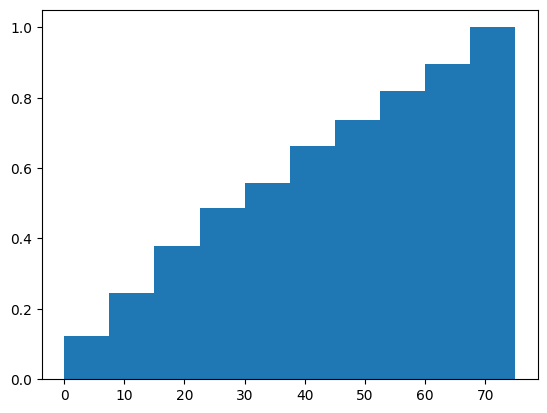

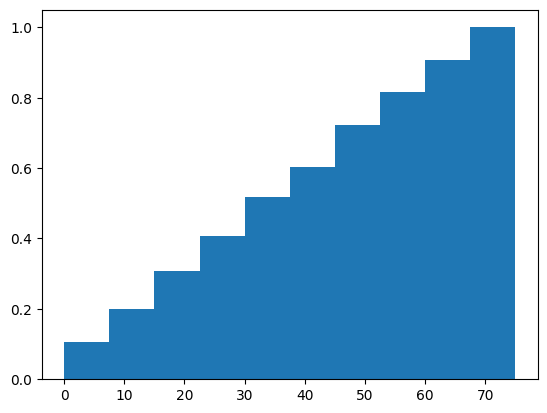

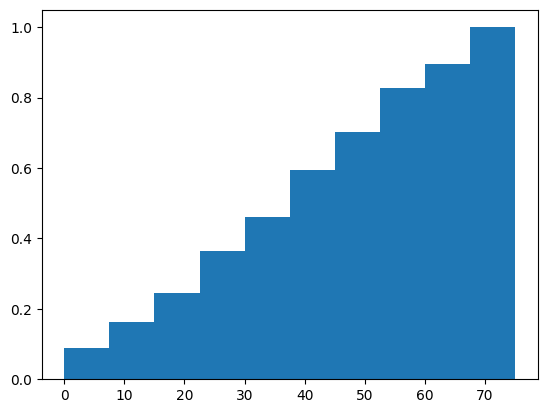

In [9]:
for i in range(3):
    plt.hist(subhalos['SubhaloPos'][:,i], cumulative=True, density=True)
    plt.show()

In [10]:
limit = 50
for i in range(3):
    subhalos = impose_cut(subhalos, subhalos['SubhaloPos'][:,i] < limit) # more than 50 star particles

In [11]:
subhalos['count']

5745

In [12]:
distance_matrix = euclidean_distances(subhalos['SubhaloPos'],subhalos['SubhaloPos']) # supposedly takes ~20 sec

In [13]:
distance_matrix.shape

(5745, 5745)

(array([ 960139., 2701350., 5224984., 6863410., 6963152., 5904948.,
        3228232.,  974324.,  176366.,    8120.]),
 array([ 0.        ,  7.91180182, 15.82360363, 23.73540497, 31.64720726,
        39.55900955, 47.47080994, 55.38261414, 63.29441452, 71.2062149 ,
        79.1180191 ]),
 <BarContainer object of 10 artists>)

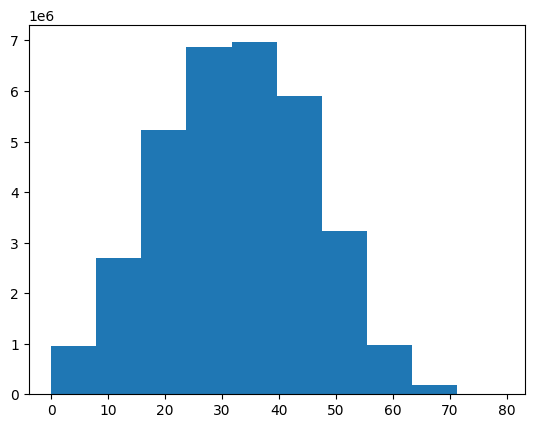

In [14]:
plt.hist((distance_matrix).flatten())

In [15]:
def normalize(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

In [16]:
distance_matrix = normalize(distance_matrix)

In [17]:
num_galaxies = subhalos['count']
edge_list = []
for i in range(num_galaxies):
    for j in range(i):
        edge_list.append((i, j, distance_matrix[i][j]))
        edge_list.append((j, i, distance_matrix[i][j])) # for directed graph hack

In [37]:
len(edge_list)

32999280

In [18]:
edge_list[:10]

[(1, 0, 0.029365536),
 (0, 1, 0.029365536),
 (2, 0, 0.0112556815),
 (0, 2, 0.0112556815),
 (2, 1, 0.02911984),
 (1, 2, 0.02911984),
 (3, 0, 0.0315939),
 (0, 3, 0.0315939),
 (3, 1, 0.027086876),
 (1, 3, 0.027086876)]

(array([6.7987670e+06, 2.5993444e+07, 4.8950822e+07, 6.5961478e+07,
        7.0511314e+07, 5.6999218e+07, 2.7294628e+07, 6.9643880e+06,
        6.6696200e+05, 6.3000000e+03]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

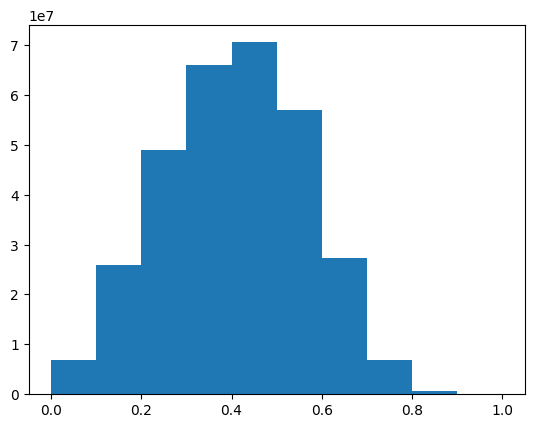

In [57]:
plt.hist((distance_matrix).flatten())

limit connections to be within 150 MPc (this is where distance metrics don't matter)

In [58]:
np.savetxt('tng50_edgelist.txt', edge_list, fmt='%d')

In [19]:
nodes, *emb = np.loadtxt("struc2vec/emb/tng_bigger.emb", skiprows=1).T

emb = np.array(emb)
nodes = np.array(nodes, dtype=np.int32)
emb = emb[:,np.argsort(nodes)] # put these in the same order as the original nodes

In [20]:
emb.shape

(50, 5745)

In [21]:
pca = PCA(n_components=3)
pca.fit(emb)
print(pca.explained_variance_ratio_)

[0.37430101 0.01639154 0.01607836]


In [22]:
components = MinMaxScaler().fit_transform(pca.components_.T).T

(array([  17.,   27.,  148.,  703., 1599., 1817., 1061.,  309.,   55.,
           9.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

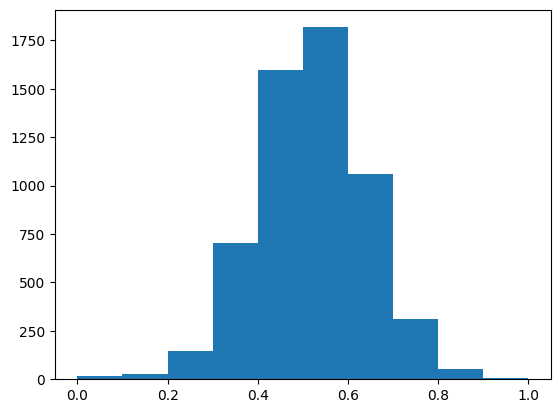

In [23]:
plt.hist(components[0])

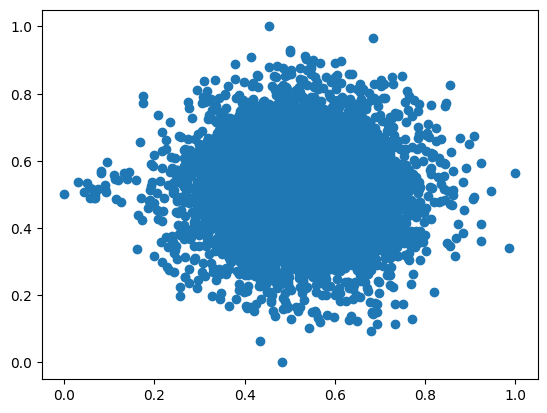

In [24]:
plt.plot(*components[[0,1]], 'o')

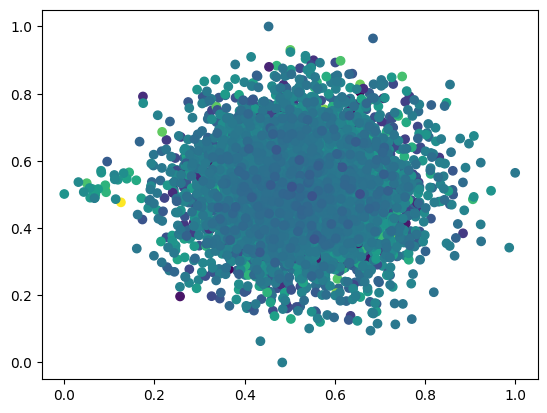

In [25]:
plt.scatter(*components[[0,1]], c = np.log10(subhalos['SubhaloMass']))

In [26]:
subhalos['SubhaloLenType'][:,1]

array([46136876,  6297959,  1420531, ...,     5159,     3954,     4680],
      dtype=int32)

/var/folders/0r/_1bnthz146q2xj0c42f4nl_80000gq/T/ipykernel_78726/465684355.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(*components[[0,1]], c = np.log10(subhalos['SubhaloLenType'][:,0]))


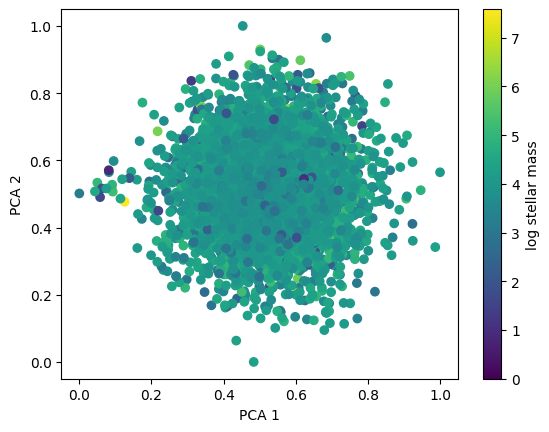

In [27]:
plt.scatter(*components[[0,1]], c = np.log10(subhalos['SubhaloLenType'][:,0]))
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="log stellar mass")

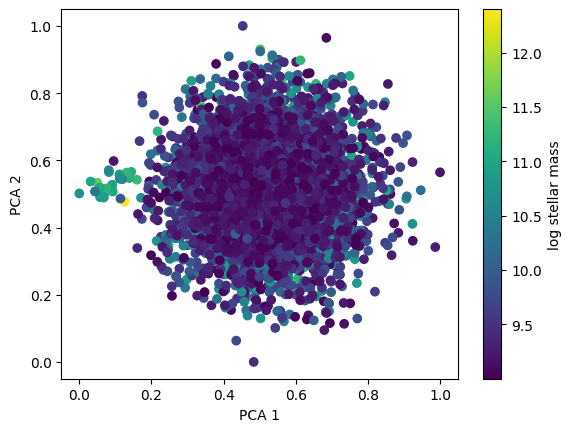

In [28]:
plt.scatter(*components[[0,1]], c = np.log10(subhalos['SubhaloMassType'][:,4] * 1e10))
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="log stellar mass")

In [29]:
subhalos.keys()

dict_keys(['count', 'SubhaloFlag', 'SubhaloMass', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloLenType', 'SubhaloStarMetallicity', 'SubhaloSFR', 'SubhaloGasMetallicity', 'SubhaloGasMetalFractions'])

In [30]:
subhalos['SubhaloStarMetallicity']

array([0.02862233, 0.02126505, 0.02540692, ..., 0.01047968, 0.01409606,
       0.01055776], dtype=float32)

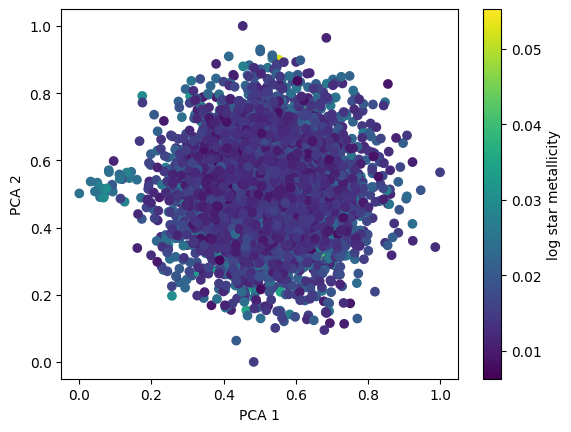

In [31]:
plt.scatter(*components[[0,1]], c = subhalos['SubhaloStarMetallicity'])
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="log star metallicity")

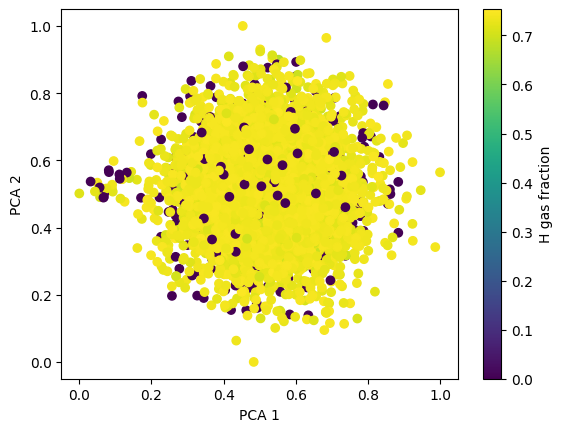

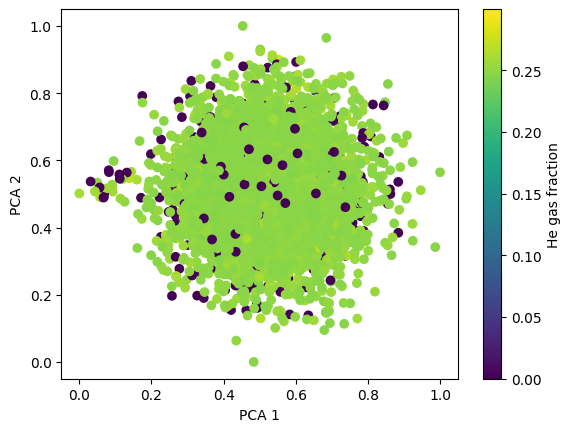

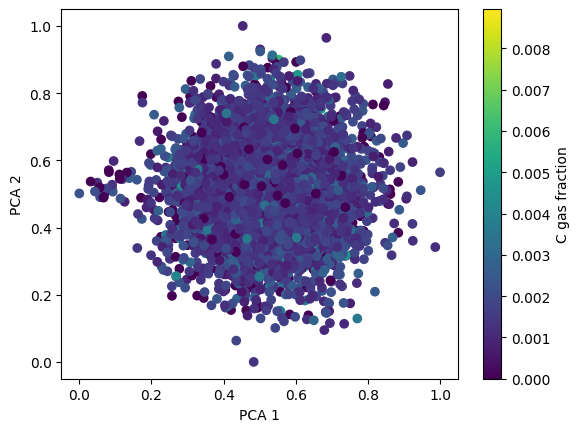

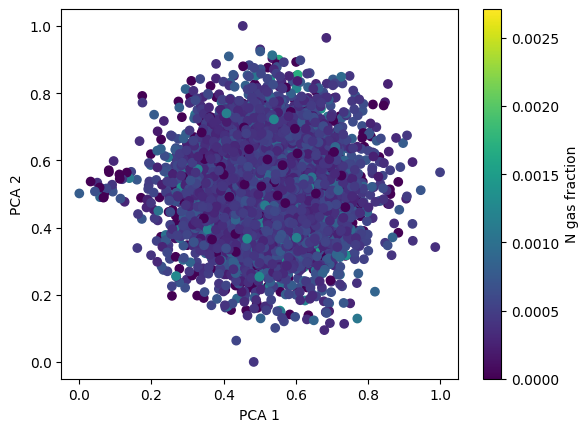

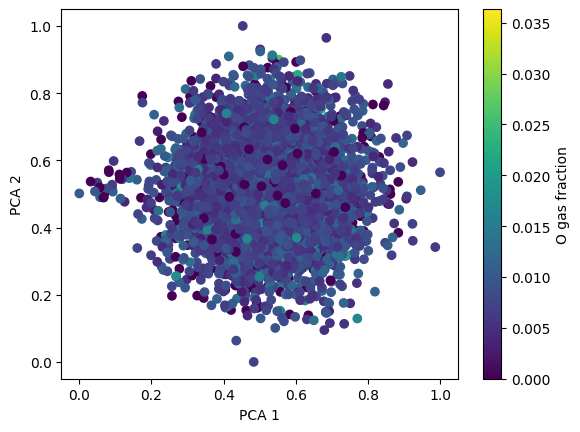

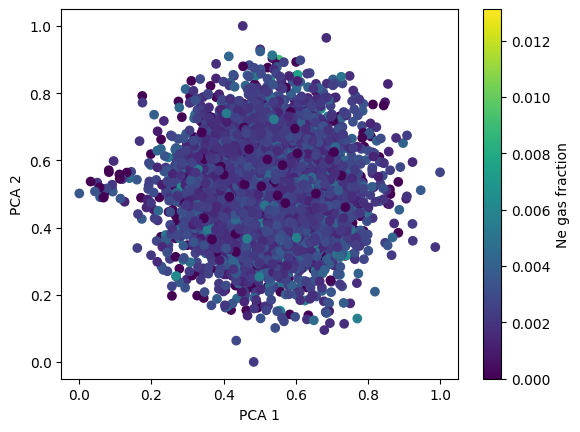

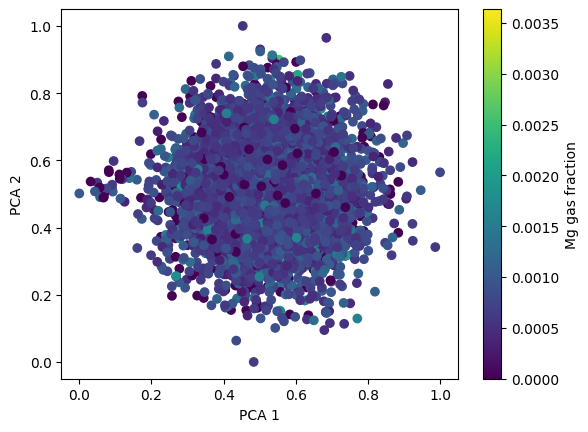

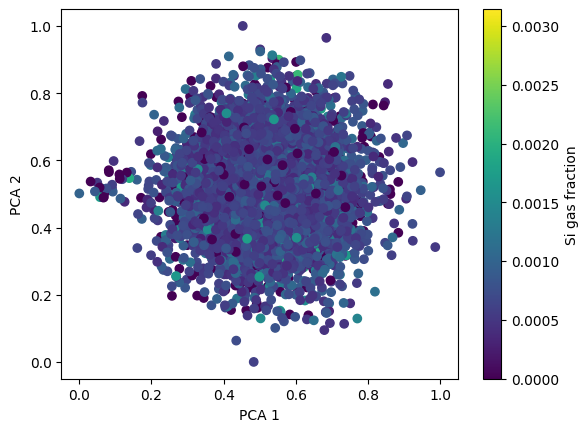

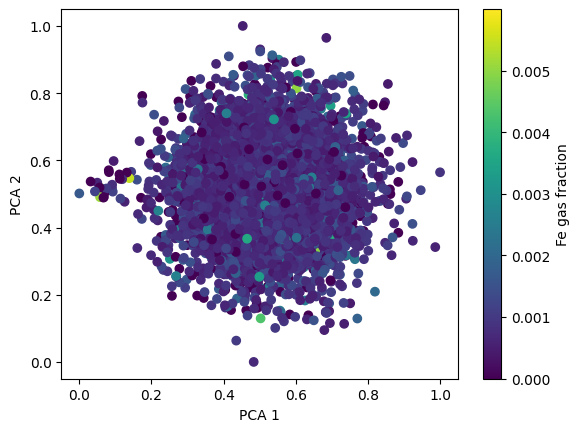

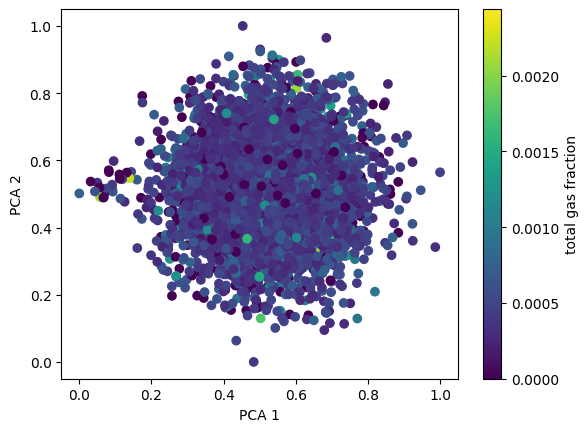

In [32]:
gases = ['H', 'He', 'C', 'N', 'O', 'Ne', 'Mg', 'Si', 'Fe', 'total']
for i in range(10):
    fig, ax = plt.subplots()
    s = ax.scatter(*components[[0,1]], c = subhalos['SubhaloGasMetalFractions'][:,i])
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    cbar = fig.colorbar(s, label=gases[i]+" gas fraction")
    plt.show()

/var/folders/0r/_1bnthz146q2xj0c42f4nl_80000gq/T/ipykernel_78726/4242542965.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(*components[[0,1]], c = np.log10(subhalos['SubhaloGasMetallicity']))


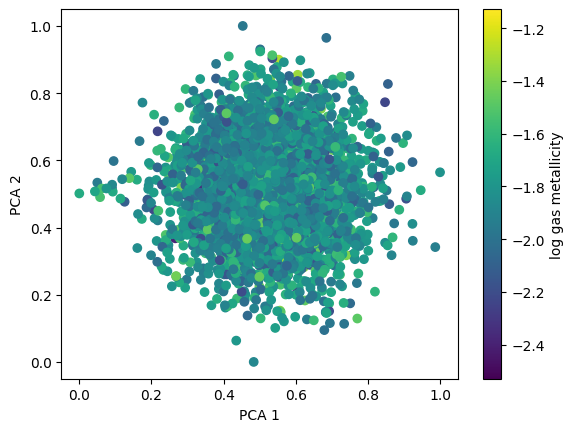

In [33]:
plt.scatter(*components[[0,1]], c = np.log10(subhalos['SubhaloGasMetallicity']))
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="log gas metallicity")

/var/folders/0r/_1bnthz146q2xj0c42f4nl_80000gq/T/ipykernel_78726/3560304120.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(*components[[0,1]], c = np.log10(subhalos['SubhaloSFR']))


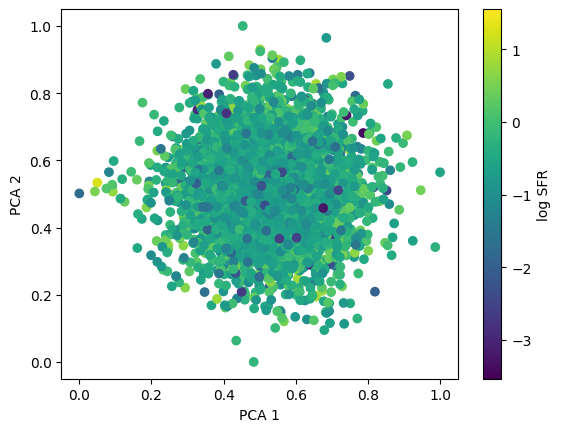

In [34]:
plt.scatter(*components[[0,1]], c = np.log10(subhalos['SubhaloSFR']))
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="log SFR")

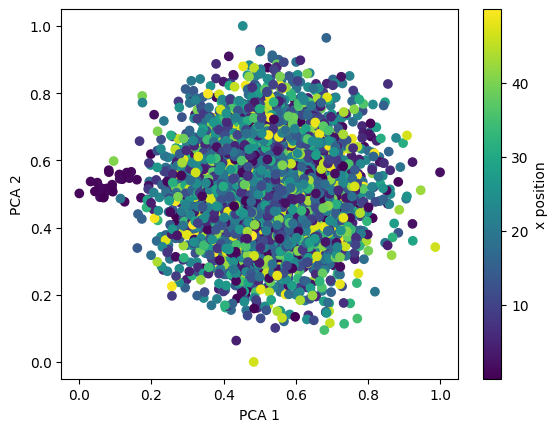

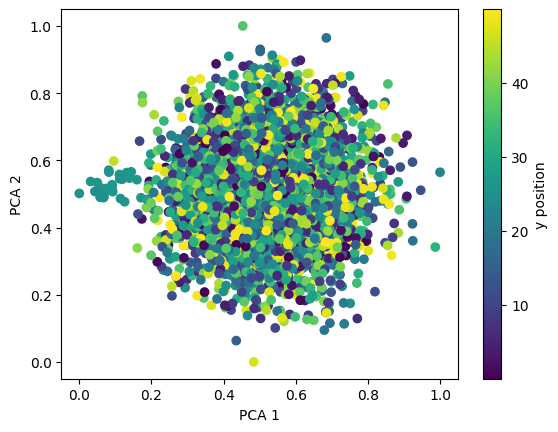

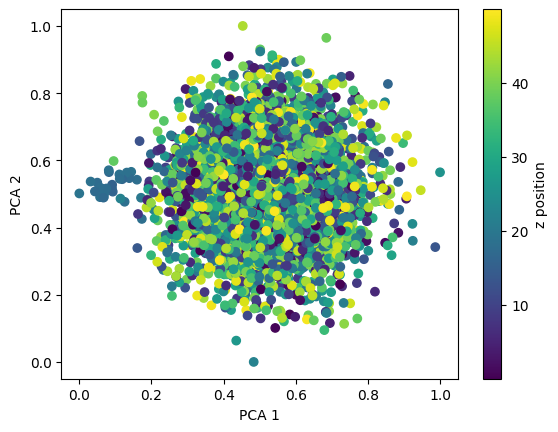

In [35]:
l = ["x", "y", "z"]
for i in range(3):
    plt.scatter(*components[[0,1]], c = subhalos['SubhaloPos'][:,i])
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.colorbar(label=l[i]+" position")
    plt.show()

In [36]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot
# df = px.data.iris()
fig = px.scatter_3d(x=subhalos['SubhaloPos'][:,0], y=subhalos['SubhaloPos'][:,1], z=subhalos['SubhaloPos'][:,2],
                    color=components[0])
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
plot(fig, filename='galaxies.html', auto_open=True)


'galaxies.html'

distance to the boundary

plot positions and color by altent representation

weights by inverse square of distance

In [589]:
G = nx.Graph()
G.add_nodes_from(np.arange(subhalos['count']))

In [590]:
# ebunch = [(i[0], i[1], {'weight':i[2]}) for i in edge_list[::2]]
ebunch = [(i[0], i[1], i[2]) for i in edge_list[::2]]

In [591]:
G.add_weighted_edges_from(ebunch)

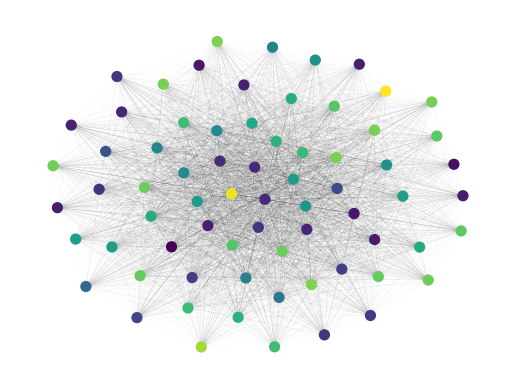

In [592]:
fig, ax = plt.subplots()
num_nodes = 70
subgraph = G.subgraph(np.arange(num_nodes))
nx.draw(subgraph, node_size=50, ax = ax, width = list(nx.get_edge_attributes(subgraph, "weight").values()), node_color = components[0][:num_nodes])

In [593]:
cmap = mpl.colormaps['Spectral']

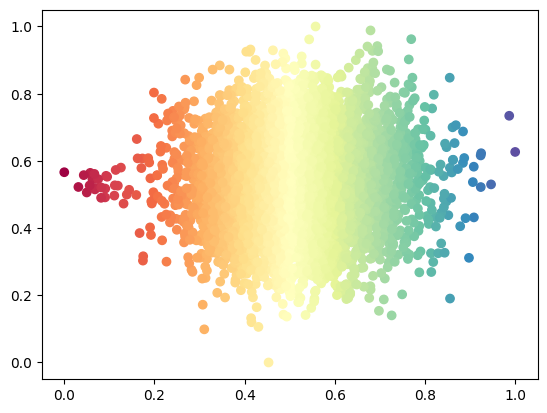

In [594]:
f = plt.scatter(components[0], components[1], c =components[0], cmap=cmap)

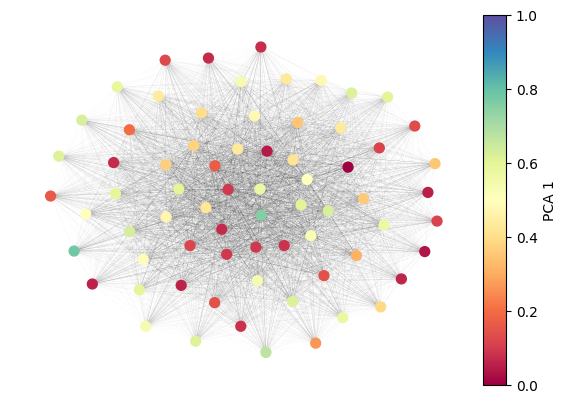

In [595]:
fig,ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
nx.draw(subgraph, pos = nx.spring_layout(subgraph), node_size=50, ax = ax, width = list(nx.get_edge_attributes(subgraph, "weight").values()), node_color = cmap(components[0][:num_nodes]))
cbar = plt.colorbar(f, cax=cax)
cbar.set_label("PCA 1")
plt.show()

In [352]:
# filename = "snap_099.0.hdf5"
# with h5py.File(filename, "r") as f:
#     # Print all root level object names (aka keys) 
#     # these can be group or dataset names 
#     print("Keys: %s" % f.keys())
#     # get first object name/key; may or may NOT be a group
#     a_group_key = list(f.keys())[0]
#     for key in f.keys():
#         print(key)
#         print(list(f[key]))
    
#     print(type(f[a_group_key])) 
